In [431]:
import numpy as np
import pickle as pl
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import pyximport
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from collections import defaultdict
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, pearsonr, skew, spearmanr, kendalltau
from sklearn.preprocessing import MinMaxScaler

In [3]:
data_df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
ml_pop = data_df.groupby("item_id").size().sort_values(ascending=False) / data_df["user_id"].nunique()

data_df = pd.read_csv("data/douban/douban.csv", sep=";", names=["user_id", "item_id", "rating"])
douban_pop = data_df.groupby("item_id").size().sort_values(ascending=False) / data_df["user_id"].nunique()

data_df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])
lfm_pop = data_df.groupby("item_id").size().sort_values(ascending=False) / data_df["user_id"].nunique()

data_df = pd.read_csv("data/goodreads/sample.csv", sep=";", names=["user_id", "item_id", "rating"])
goodreads_pop = data_df.groupby("item_id").size().sort_values(ascending=False) / data_df["user_id"].nunique()

data_df = pd.read_csv("data/ciao/ciao.csv", sep=";", names=["user_id", "item_id", "rating"])
ciao_pop = data_df.groupby("item_id").size().sort_values(ascending=False) / data_df["user_id"].nunique()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [585]:
skew(ml_pop), np.mean(sorted(ml_pop, reverse=True)[:25]), np.max(ml_pop) / np.mean(ml_pop), np.mean(ml_pop)

(2.8137964915837013,
 0.41888079470198675,
 12.701513383702864,
 0.04468362562231264)

In [586]:
skew(douban_pop), np.mean(sorted(douban_pop, reverse=True)[:25]), np.max(douban_pop) / np.mean(douban_pop), np.mean(douban_pop)

(6.600508908788999,
 0.3803427660422479,
 54.12178272666009,
 0.008999087014264884)

In [587]:
skew(lfm_pop), np.mean(sorted(lfm_pop, reverse=True)[:25]), np.max(lfm_pop) / np.mean(lfm_pop), np.mean(lfm_pop)

(20.25472855182974,
 0.3779466666666667,
 279.17114770580855,
 0.001658480841608714)

In [588]:
skew(goodreads_pop), np.mean(sorted(goodreads_pop, reverse=True)[:25]), np.max(goodreads_pop) / np.mean(goodreads_pop), np.mean(goodreads_pop)

(62.456785399600975, 0.196996, 1352.9312180428271, 0.00025252577177887624)

In [589]:
skew(ciao_pop), np.mean(sorted(ciao_pop, reverse=True)[:25]), np.max(ciao_pop) / np.mean(ciao_pop), np.mean(ciao_pop)

(36.95443486619619,
 0.05461152542372881,
 340.2561045069054,
 0.00036463062665684394)

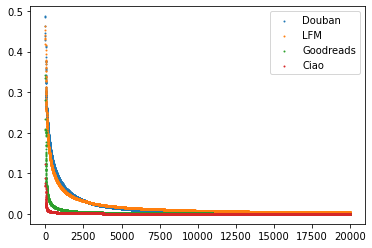

In [9]:
n = 20000
#plt.scatter(range(n), sorted(ml_pop, reverse=True)[:n], s=1, label="MovieLens 1M")
plt.scatter(range(n), sorted(douban_pop, reverse=True)[:n], s=1, label="Douban")
plt.scatter(range(n), sorted(lfm_pop, reverse=True)[:n], s=1, label="LFM")
plt.scatter(range(n), sorted(goodreads_pop, reverse=True)[:n], s=1, label="Goodreads")
plt.scatter(range(n), sorted(ciao_pop, reverse=True)[:n], s=1, label="Ciao")
plt.legend()

In [743]:
#data_df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
#data_df.drop(columns=["timestamp"], inplace=True)
data_df = pd.read_csv("data/ciao/ciao.csv", sep=";", names=["user_id", "item_id", "rating"])
#data_df = pd.read_csv("data/douban/douban.csv", sep=";", names=["user_id", "item_id", "rating"])
#data_df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])
#data_df = pd.read_csv("data/goodreads/sample.csv", sep=";", names=["user_id", "item_id", "rating"])

sample = np.random.choice(data_df["user_id"].unique(), size=1000, replace=False)
data_df = data_df[data_df["user_id"].isin(sample)]

dataset = Dataset.load_from_df(data_df, reader=Reader(rating_scale=(1, 5)))
#dataset = Dataset.load_from_df(data_df, reader=Reader(rating_scale=(1, 1000)))
trainset, testset = train_test_split(dataset, test_size=0.2)

sim = UserKNN.compute_similarities(trainset, min_support=1)
pop = UserKNN.compute_popularities(trainset)
gain = UserKNN.compute_gain(trainset)

In [679]:
top_10_bobs = dict()
for alice, gain_bobs in enumerate(gain):
    top_10_bobs_for_alice = np.argsort(gain_bobs)[::-1][:10]
    top_10_bobs[alice] = top_10_bobs_for_alice

jaccard = []
for alice1, bobs1 in top_10_bobs.items():
    jaccard_alice1 = []
    for alice2, bobs2 in top_10_bobs.items():
        overlap = len(set(bobs1).intersection(bobs2))
        union = len(set(bobs1).union(bobs2))
        j = overlap / union
        jaccard_alice1.append(j)
    jaccard.append(np.mean(jaccard_alice1))
np.mean(jaccard)

0.02629693622974892

In [680]:
top_10_bobs = dict()
for alice, sims_bobs in enumerate(sim):
    top_10_bobs_for_alice = np.argsort(sims_bobs)[::-1][:10]
    top_10_bobs[alice] = top_10_bobs_for_alice

jaccard = []
for alice1, bobs1 in top_10_bobs.items():
    jaccard_alice1 = []
    for alice2, bobs2 in top_10_bobs.items():
        overlap = len(set(bobs1).intersection(bobs2))
        union = len(set(bobs1).union(bobs2))
        j = overlap / union
        jaccard_alice1.append(j)
    jaccard.append(np.mean(jaccard_alice1))
np.mean(jaccard)

0.01669935618629736

In [636]:
np.mean(sim)

0.395556001057417

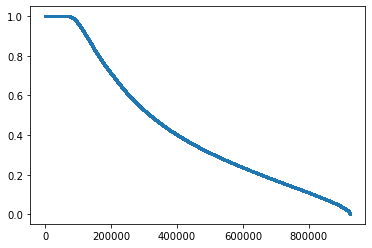

In [637]:
sim_ = sim[sim > 0]
plt.scatter(range(sim_.size), sorted(sim_.ravel(), reverse=True), s=1)

In [638]:
np.mean(sim_)

0.42779830360339816

In [639]:
skew(sim_.ravel())

0.6312880641985186

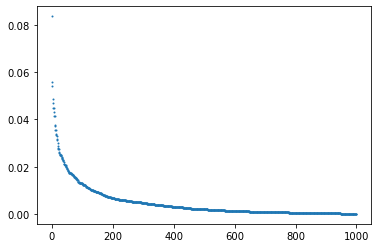

In [567]:
pop_ = pop[pop > 0]
plt.scatter(range(pop_.size), sorted(pop_, reverse=True), s=1)

In [568]:
skew(pop_)

3.7332496136198223

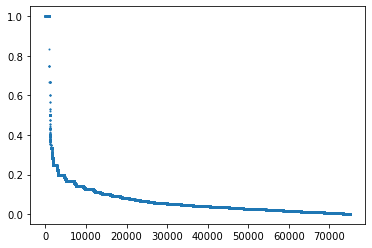

In [569]:
gain_ = gain[gain > 0]
plt.scatter(range(gain_.size), sorted(gain_.ravel(), reverse=True), s=1)

In [531]:
skew(gain_.ravel())

5.777975649362377

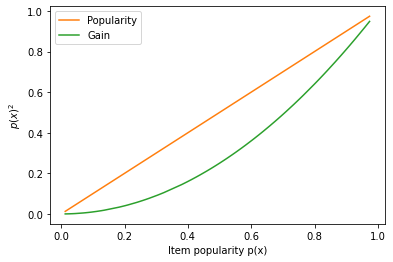

In [532]:
def f(x):
    return np.power(x, 2)

x = sorted(np.random.uniform(0, 1, 100))[::-1]
plt.plot(x, x, c="C1", label="Popularity")
plt.plot(x, f(x), c="C2", label="Gain")
plt.ylabel(r"$p(x)^2$")
plt.xlabel("Item popularity p(x)")
plt.legend()

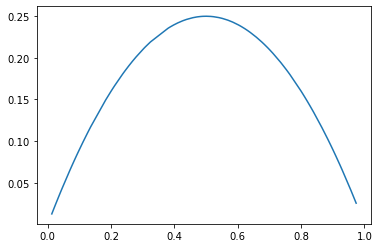

In [533]:
plt.plot(x, x-f(x))

In [466]:
def f(df):
    n_popular = int(df["item_id"].nunique() * 0.2)
    most_popular_items = df.groupby("item_id").size().sort_values(ascending=False).head(n_popular).index.tolist()
    fractions = np.zeros(trainset.n_users)
    for uid, ratings in trainset.ur.items():
        rated_items = {trainset.to_raw_iid(iiid) for iiid, _ in ratings}
        frac = len(rated_items.intersection(most_popular_items)) / len(ratings)
        fractions[uid] = frac
    return fractions

fractions = f(data_df)

top_sim_users = np.argsort(sim.mean(axis=0))[::-1][:10]
top_pop_users = np.argsort(pop)[::-1][:10]
top_gain_users = np.argsort(gain.mean(axis=0))[::-1][:10]
np.mean(fractions[top_sim_users]), np.mean(fractions[top_pop_users]), np.mean(fractions[top_gain_users])

(0.6007915295744958, 0.5290805738388293, 0.5798209212354665)

In [ ]:
testset_u = defaultdict(list)
for uid, iid, r in testset:
    testset_u[uid].append((uid, iid, r))
new_testset_u = dict()
for uid, data in testset_u.items():
    if len(data) >= 100:
        new_testset_u[uid] = data
testset_u = new_testset_u

testset_u = defaultdict(list)
for uid, iid, r in testset:
    testset_u[uid].append((uid, iid, r))
n_testset_u = np.zeros(trainset.n_users)
for uid in trainset.all_users():
    ruid = trainset.to_raw_uid(uid)
    n_testset_u[uid] = len(testset_u[ruid])

In [ ]:
# UserKNN
m = UserKNN(k=10, precomputed_sim=sim, reuse=False)
m.fit(trainset)
sim_start = dict()
sim_end = dict()
for u in testset_u.keys():
    _ = m.test(testset_u[u][:10])
    iuid = trainset.to_inner_uid(u)
    avg_sim_start = np.mean([m.sim[iuid, u_] for u_ in m.mentors[iuid]])
        
    _ = m.test(testset_u[u])
    iuid = trainset.to_inner_uid(u)
    avg_sim_end = np.mean([m.sim[iuid, u_] for u_ in m.mentors[iuid]])

    sim_start[iuid] = avg_sim_start
    sim_end[iuid] = avg_sim_end

# UserKNN
m = UserKNN(k=10, precomputed_sim=sim, reuse=True)
m.fit(trainset)
sim_start_r = dict()
sim_end_r = dict()
for u in testset_u.keys():
    _ = m.test(testset_u[u][:10])
    iuid = trainset.to_inner_uid(u)
    avg_sim_start = np.mean([m.sim[iuid, u_] for u_ in m.mentors[iuid]])
        
    _ = m.test(testset_u[u])
    iuid = trainset.to_inner_uid(u)
    avg_sim_end = np.mean([m.sim[iuid, u_] for u_ in m.mentors[iuid]])
    
    sim_start_r[iuid] = avg_sim_start
    sim_end_r[iuid] = avg_sim_end

n_within = []
for ruid in testset_u.keys():
    iuid = trainset.to_inner_uid(ruid)
    within_range = np.where(np.logical_and(sim[iuid] >= sim_end[iuid], sim[iuid] <= sim_start[iuid]))[0]
    n_within.append(len(within_range))
print(np.mean(n_within) / trainset.n_users)

n_within = []
for ruid in testset_u.keys():
    iuid = trainset.to_inner_uid(ruid)
    within_range = np.where(np.logical_and(sim[iuid] >= sim_end_r[iuid], sim[iuid] <= sim_start_r[iuid]))[0]
    n_within.append(len(within_range))
print(np.mean(n_within) / trainset.n_users)

In [655]:
def mean_nonzero(a, axis=0):
    return np.sum(a, axis=axis) / len(np.count_nonzero(a, axis=axis))

# UserKNN
m = UserKNN(k=10, precomputed_sim=sim, reuse=False)
m.fit(trainset)
_ = m.test(testset)
print(m.sim.mean(axis=0).dot(m.n_queries) / np.sum(m.n_queries))

# UserKNN+Reuse
m = UserKNN(k=10, precomputed_sim=sim, reuse=True)
m.fit(trainset)
_ = m.test(testset)
print(m.sim.mean(axis=0).dot(m.n_queries) / np.sum(m.n_queries))

# Popularity
m = UserKNN(k=10, precomputed_sim=sim, precomputed_pop=pop, reuse=False, tau_2=0.5)
m.fit(trainset)
_ = m.test(testset)
print(m.sim.mean(axis=0).dot(m.n_queries) / np.sum(m.n_queries))
    
# Popularity+Reuse
m = UserKNN(k=10, precomputed_sim=sim, precomputed_pop=pop, reuse=True, tau_2=0.5)
m.fit(trainset)
_ = m.test(testset)
print(m.sim.mean(axis=0).dot(m.n_queries) / np.sum(m.n_queries))
    
# Gain
m = UserKNN(k=10, precomputed_sim=sim, precomputed_gain=gain, reuse=False, tau_4=0.5)
m.fit(trainset)
_ = m.test(testset)
print(m.sim.mean(axis=0).dot(m.n_queries) / np.sum(m.n_queries))
    
# Gain+Reuse
m = UserKNN(k=10, precomputed_sim=sim, precomputed_gain=gain, reuse=True, tau_4=0.5)
m.fit(trainset)
_ = m.test(testset)
print(m.sim.mean(axis=0).dot(m.n_queries) / np.sum(m.n_queries))

0.1502228206838784
0.1523633890847255
0.16465033423556566
0.16495513241249674
0.15774046314239393
0.15879845981586746


In [481]:
overlap = []
i = 0
for alice, ratings_a in trainset.ur.items():
    i += 1
    if i % 100 == 0:
        print(i)
    items_a = set(iid for iid, _ in ratings_a)
    overlap_with_bob = []
    for bob, ratings_b in trainset.ur.items():
        if alice != bob:
            items_b = set(iid for iid, _ in ratings_b)
            overlap_with_bob.append(len(items_a.intersection(items_b)))
    overlap.append(np.mean(overlap_with_bob))
np.mean(overlap)

100
200
300
400
500
600
700
800
900
1000


13.748598598598598

In [735]:
def get_popularity_bias_of_neighbors(m, user_pop):
    """popfrac_of_neighbors = np.zeros(m.trainset.n_users)
    for iuid, n_queries in enumerate(m.n_queries):
        rated_items = {m.trainset.to_raw_iid(iiid) for iiid, _ in m.trainset.ur[iuid]}
        frac = len(rated_items.intersection(popular_items)) / len(m.trainset.ur[iuid])
        popfrac_of_neighbors[iuid] = frac
        
    return np.dot(popfrac_of_neighbors, m.n_queries) / np.sum(m.n_queries)"""
    
    """frac = np.zeros(m.trainset.n_users)
    for uid, ratings in m.trainset.ur.items():
        rated_items = {m.trainset.to_raw_iid(iiid) for iiid, _ in ratings}
        #f = len(rated_items.intersection(popular_items)) / len(ratings)
        f = len(rated_items.difference(popular_items)) / len(ratings)
        frac[uid] = f"""
    
    
    """avg_neighbor_frac = []
    for _, neighbors in m.mentors.items():
        neighbor_frac = [item_popularity[bob] for bob in neighbors]
        avg_neighbor_frac.append(np.mean(neighbor_frac))
    return np.mean(avg_neighbor_frac)"""
    
    pops = []
    for _, neighbors in m.mentors.items():
        pops.append(np.mean([user_pop[n] for n in neighbors]))
    return np.mean(pops), np.std(pops)
    
    
def unique_neighbors(m):
    """neighbor_freq = np.zeros(m.trainset.n_users)
    for _, neighbors in m.mentors.items():
        for n in neighbors:
            neighbor_freq[n] += 1
    return np.mean(neighbor_freq[neighbor_freq > 0])"""
    jaccards = []
    for user1, neighbors1 in m.mentors.items():
        n1 = set(neighbors1)
        jaccard_n1 = []
        for user2, neighbors2 in m.mentors.items():
            n2 = set(neighbors2)
            j = len(n1.intersection(n2)) / len(n1.union(n2))
            jaccard_n1.append(j)
        jaccards.append(np.mean(jaccard_n1))
    return np.mean(jaccards)

def get_size_of_user_profile(m):
    x = np.zeros(m.trainset.n_users)
    for iuid, ratings in m.trainset.ur.items():
        x[iuid] = len(ratings)
    
    sizes = []
    for alice, neighbors in m.mentors.items():
        s = []
        for bob in neighbors:
            s.append(x[bob])
        sizes.append(np.mean(s))
    
    return np.mean(sizes)


def neighbors(m, n):
    """n_ratings = np.zeros(m.trainset.n_users)
    for uid, ratings in m.trainset.ur.items():
        n_ratings[uid] = len(ratings)
        
    return np.dot(n_ratings, m.n_queries) / np.sum(m.n_queries)"""
    
    
    """avg_std = []
    for alice, neighbors in m.mentors.items():
        item_ratings = defaultdict(list)
        for bob in neighbors:
            for iid, r in m.trainset.ur[bob]:
                item_ratings[iid].append(r)
        avg_std.append(np.mean([np.std(ratings) for iid, ratings in item_ratings.items()]))
    return np.mean(avg_std)"""
    
    overlaps = []
    for alice, neighbors in m.mentors.items():
        items_a = set(iid for iid, _ in trainset.ur[alice])
        overlaps_a = []
        for bob in neighbors:
            items_b = set(iid for iid, _ in trainset.ur[bob])
            overlap_ab = len(items_a.intersection(items_b)) / len(items_a)
            overlaps_a.append(overlap_ab)
        overlaps.append(np.mean(overlaps_a))
    return np.mean(overlaps), np.std(overlaps)
        
    
    """n_covered_items = np.zeros(m.trainset.n_users)
    n_neighbors = np.zeros(m.trainset.n_users)
    n_ratings = np.zeros(m.trainset.n_users)
    similarity = np.zeros(m.trainset.n_users)
    for alice, neighbors in m.mentors.items():
        items_in_neighborhood = set()
        sims_in_neighborhood = []
        n_ratings_in_neighborhood = 0
        items_a = set(iid for iid, _ in trainset.ur[alice])
        for bob in neighbors:
            items_b = {iid for iid, _ in m.trainset.ur[bob]}
            items_in_neighborhood = items_in_neighborhood.union(items_b)
            sims_in_neighborhood.append(m.sim[alice, bob])
            n_ratings_in_neighborhood += len(items_b)
        n_covered_items[alice] = len(items_in_neighborhood)
        similarity[alice] = np.mean(sims_in_neighborhood)
        n_ratings[alice] = n_ratings_in_neighborhood
        n_neighbors[alice] = len(neighbors)
    #density = n_ratings / (n_neighbors * n_ratings)
    density = n_ratings / (n_neighbors * m.trainset.n_items)
    
    frac_covered_items = n_covered_items / m.trainset.n_items
    return np.mean(frac_covered_items), np.mean(similarity), np.nanmean(density), np.mean(n_ratings)"""
    
        
        
    
    """item_frequencies = np.zeros(m.trainset.n_items)
    for n, q in enumerate(m.n_queries):
        for iid, _ in m.trainset.ur[n]:
            item_frequencies[iid] += q
    item_frequencies /= np.sum(item_frequencies)
    
    return -np.sum(item_frequencies * np.log(item_frequencies+1e-10))"""

    """user_entropy = np.zeros(m.trainset.n_users)
    for uid, ratings in m.trainset.ur.items():
        p = np.array([item_popularity[m.trainset.to_raw_iid(iid)] for iid, _ in ratings])
        p = p / np.sum(p)
        user_entropy[uid] = -np.sum(p * np.log2(p))
    
    return np.dot(user_entropy, m.n_queries) / np.sum(m.n_queries)"""
    
    """i = 1
    neighbor_entropy = []
    for uid, neighbors in m.mentors.items():
        item_frequencies = np.zeros(m.trainset.n_items)
        for n in neighbors:
            for iid, _ in m.trainset.ur[n]:
                item_frequencies[iid] += 1
        p = []
        for iid, freq in enumerate(item_frequencies):
            p.append(freq * item_popularity[m.trainset.to_raw_iid(iid)])
        p = np.array(p) / np.sum(p)
        epsilon = 1e-26
        neighbor_entropy.append(-np.sum((p+epsilon) * np.log2(p+epsilon)))
        
        print(i)
        i += 1
        
        
    return np.mean(neighbor_entropy)"""
    
    
        

    
    
    #fractions = np.zeros(m.trainset.n_users)
    #for uid, ratings in m.trainset.ur.items():
    #    rated_items = {m.trainset.to_raw_iid(iiid) for iiid, _ in ratings}
    #    frac = len(rated_items.intersection(popular_items)) / len(ratings)
    #    fractions[uid] = frac
        
    #return np.dot(fractions, m.n_queries) / np.sum(m.n_queries)
    
    #top_neighbors = np.argsort(m.n_queries)[::-1][:10]
    #return np.sum([fractions[n] * m.n_queries[n] for n in top_neighbors]) / np.sum(m.n_queries[top_neighbors])

In [726]:
n_popular = int(data_df["item_id"].nunique() * 0.2)
most_popular_items = data_df.groupby("item_id").size().sort_values(ascending=False).head(n_popular).index.tolist()
fractions = np.zeros(trainset.n_users)
for uid, ratings in trainset.ur.items():
    rated_items = {trainset.to_raw_iid(iiid) for iiid, _ in ratings}
    frac = len(rated_items.intersection(most_popular_items)) / len(ratings)
    fractions[uid] = frac

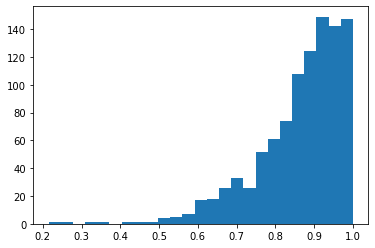

In [727]:
plt.hist(fractions, bins=25);

In [728]:
item_popularity = data_df.groupby("item_id").size() / data_df["user_id"].nunique()
item_pop = np.zeros(trainset.n_items)
        
for iiid in trainset.all_items():
    riid = trainset.to_raw_iid(iiid)
    p = item_popularity[riid]
    item_pop[iiid] = p

In [729]:
pop = UserKNN.compute_popularities(trainset)

In [744]:
#Ks = [5, 10, 15, 20, 25, 30]
Ks = [10]
for k_idx, k in enumerate(Ks):
    print()
    print("------ k=%d ------" % k)
    
    # UserKNN
    m = UserKNN(k=k, precomputed_sim=sim, reuse=False)
    m.fit(trainset)
    _ = m.test(testset)
    #print(get_popularity_bias_of_neighbors(m, pop))
    print(neighbors(m, n_testset_u))
    #print(unique_neighbors(m))
    
    # UserKNN+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, reuse=True)
    m.fit(trainset)
    _ = m.test(testset)
    #print(get_popularity_bias_of_neighbors(m, pop))
    print(neighbors(m, n_testset_u))
    #print(unique_neighbors(m))
    
    
    # Popularity
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop, reuse=False, tau_2=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    #print(get_popularity_bias_of_neighbors(m, pop))
    print(neighbors(m, n_testset_u))
    #print(unique_neighbors(m))
    
    
    # Popularity+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop, reuse=True, tau_2=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    #print(get_popularity_bias_of_neighbors(m, pop))
    print(neighbors(m, n_testset_u))
    #print(unique_neighbors(m))
    
    
    # Gain
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, reuse=False, tau_4=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    #print(get_popularity_bias_of_neighbors(m, pop))
    print(neighbors(m, n_testset_u))
    #print(unique_neighbors(m))
    
    
    # Gain+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, reuse=True, tau_4=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    #print(get_popularity_bias_of_neighbors(m, pop))
    print(neighbors(m, n_testset_u))
    #print(unique_neighbors(m))
    


------ k=10 ------
(0.02666619532714967, 0.036015350790869836)
(0.026650782595144955, 0.03597466133583289)
(0.028870533842368592, 0.040094681613575454)
(0.028821867155515594, 0.03983804528295811)
(0.03011625501543229, 0.04291674172288536)
(0.030113379314012596, 0.04322567427016129)
